# SIFT_Product_Recognition_Explanation

## Explicación de la Lógica de Detección y Clasificación de Productos usando SIFT

Este cuaderno explica la lógica implementada en la carpeta py para el reconocimiento de productos utilizando el algoritmo SIFT (Scale-Invariant Feature Transform).

- Jorge Cueva
- Mateo Barzallo
- Karen Quito

### Contenido

1. Introducción a SIFT
2. Arquitectura del Sistema
3. Motor SIFT (sift_engine.py)
4. API Flask (app.py)
5. Ejemplos de Uso
   - 5.1 Ejemplo Práctico con Imagen Real: Chicles.jpg
6. Conclusiones

## 1. Introducción a SIFT

SIFT (Scale-Invariant Feature Transform) es un algoritmo para la detección y descripción de puntos clave locales en imágenes. Fue desarrollado por David Lowe en 1999 y publicado en 2004.

### Características principales de SIFT:

- **Invariante a escala**: Detecta puntos clave independientemente del tamaño de la imagen
- **Invariante a rotación**: Los descriptores son rotacionalmente invariantes
- **Invariante a iluminación**: Robusto a cambios en la iluminación
- **Parcialmente invariante a cambios de perspectiva**: Maneja cierto grado de cambios 3D

### Cómo funciona SIFT:

1. **Detección de puntos de interés**: Encuentra puntos que son estables bajo transformaciones
2. **Asignación de orientación**: Asigna una orientación dominante a cada punto clave
3. **Descripción de características**: Crea un vector descriptor de 128 dimensiones para cada punto clave

### Aplicaciones:

- Reconocimiento de objetos
- Clasificación de imágenes
- Emparejamiento de imágenes (image matching)
- Reconstrucción 3D
- En este proyecto: Reconocimiento de productos en imágenes de supermercado

## 2. Arquitectura del Sistema

El sistema está compuesto por tres capas principales:

### 2.1 Motor SIFT (sift_engine.py)

- **Clase SIFTEngine**: Contiene toda la lógica de procesamiento SIFT
- **Base de datos en memoria**: Diccionario que almacena descriptores por nombre de producto
- **Funciones principales**:
  - `register_product()`: Registra un producto extrayendo sus descriptores SIFT
  - `detect_keypoints_vis()`: Visualiza puntos clave detectados
  - `identify_product()`: Identifica productos comparando descriptores

### 2.2 API Flask (app.py)

- **Servidor web**: Expone endpoints REST para interactuar con el motor SIFT
- **Endpoints principales**:
  - `POST /register`: Registra nuevos productos
  - `POST /preview_keypoints`: Previsualiza puntos clave
  - `POST /predict`: Identifica productos en imágenes
- **Manejo de CORS**: Permite peticiones desde el frontend

### 2.3 Integración con MLflow

- **Seguimiento de experimentos**: Registra versiones del modelo
- **Métricas**: Número de productos registrados
- **Restauración**: Permite volver a versiones anteriores

### Flujo de trabajo:

1. **Registro**: Imagen → SIFT → Descriptores → Base de datos
2. **Predicción**: Imagen → SIFT → Comparación → Producto identificado

In [1]:
# Importar librerías necesarias
import cv2
import numpy as np
import matplotlib.pyplot as plt
# Configurar matplotlib para mostrar imágenes en el notebook
%matplotlib inline

## 3. Motor SIFT - Implementación Detallada

La clase `SIFTEngine` es el corazón del sistema. Analicemos su funcionamiento paso a paso.

In [2]:
class SIFTEngine:
    """
    Motor de reconocimiento de productos basado en SIFT.
    Implementa la lógica completa de detección, descripción y matching de características.
    """

    def __init__(self, storage_path="sift_data.pkl"):
        self.storage_path = storage_path
        # Crear detector SIFT con parámetros por defecto
        self.sift = cv2.SIFT_create()
        # Base de datos en memoria: {nombre_producto: descriptores}
        self.database = {}

    def register_product(self, name, image_bgr, mask=None, contrast_threshold=0.04, edge_threshold=10):
        """
        Registra un producto en la base de datos.

        Parámetros:
        - name: Nombre del producto
        - image_bgr: Imagen en formato BGR (OpenCV)
        - mask: Máscara binaria opcional para enfocar la detección
        - contrast_threshold: Umbral de contraste para filtrar puntos débiles
        - edge_threshold: Umbral para filtrar puntos tipo borde
        """
        # Convertir a escala de grises
        gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)

        # Configurar SIFT con parámetros personalizados si es necesario
        if contrast_threshold != 0.04 or edge_threshold != 10:
            self.sift = cv2.SIFT_create(contrastThreshold=contrast_threshold,
                                        edgeThreshold=edge_threshold)
        else:
            self.sift = cv2.SIFT_create()

        # Detectar keypoints y computar descriptores
        keypoints, descriptors = self.sift.detectAndCompute(gray, mask)

        if descriptors is None:
            return False, "No se detectaron características en la imagen."

        # Almacenar descriptores en la base de datos
        self.database[name] = descriptors
        return True, f"Producto '{name}' registrado con {len(keypoints)} características."

    def detect_keypoints_vis(self, image_bgr, mask=None, contrast_threshold=0.04, edge_threshold=10):
        """
        Detecta keypoints y retorna imagen con visualización.

        Esta función es útil para previsualizar qué puntos clave se detectarán
        antes de registrar un producto.
        """
        gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)

        # Crear detector SIFT temporal con parámetros específicos
        sift_temp = cv2.SIFT_create(contrastThreshold=contrast_threshold,
                                    edgeThreshold=edge_threshold)

        # Detectar keypoints
        keypoints = sift_temp.detect(gray, mask)

        # Dibujar keypoints en la imagen
        vis_img = cv2.drawKeypoints(image_bgr, keypoints, None,
                                    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

        return vis_img, len(keypoints)

    def identify_product(self, query_image_bgr, min_match_count=10):
        """
        Identifica un producto comparando la imagen de consulta con la base de datos.

        Algoritmo:
        1. Extraer descriptores SIFT de la imagen de consulta
        2. Para cada producto en la base de datos:
           - Usar BFMatcher con KNN (k=2)
           - Aplicar ratio test de Lowe (0.75)
           - Contar matches "buenos"
        3. Retornar el producto con más matches si supera el umbral mínimo

        Parámetros:
        - query_image_bgr: Imagen a identificar
        - min_match_count: Número mínimo de matches para considerar una identificación válida

        Retorna:
        - (label, num_matches) si identificado, (None, num_matches) si no
        """
        # Convertir imagen de consulta a escala de grises
        gray_query = cv2.cvtColor(query_image_bgr, cv2.COLOR_BGR2GRAY)

        # Extraer keypoints y descriptores
        kp_q, des_q = self.sift.detectAndCompute(gray_query, None)

        if des_q is None:
            return None, 0

        # Crear matcher BFMatcher
        bf = cv2.BFMatcher()
        best_label = None
        max_matches = 0

        # Comparar con cada producto registrado
        for name, des_ref in self.database.items():
            if des_ref is None:
                continue

            # Encontrar mejores matches usando KNN con k=2
            matches = bf.knnMatch(des_ref, des_q, k=2)

            # Aplicar ratio test de Lowe
            good_matches = []
            for m, n in matches:
                if m.distance < 0.75 * n.distance:
                    good_matches.append(m)

            # Actualizar mejor coincidencia
            if len(good_matches) > max_matches:
                max_matches = len(good_matches)
                best_label = name

        # Verificar si supera el umbral mínimo
        if max_matches >= min_match_count:
            return best_label, max_matches
        else:
            return None, max_matches

In [3]:
# Singleton pattern para asegurar una única instancia del motor SIFT
_sift_instance = None

def get_sift_engine(storage_path="sift_data.pkl"):
    """
    Factory function que retorna la instancia singleton del motor SIFT.
    Esto asegura que todos los módulos usen la misma base de datos.
    """
    global _sift_instance
    if _sift_instance is None:
        _sift_instance = SIFTEngine(storage_path)
    return _sift_instance

### Algoritmo de Matching Explicado

El método `identify_product` utiliza el **BFMatcher** (Brute Force Matcher) con la técnica **KNN** (K-Nearest Neighbors) y el **Ratio Test de Lowe**:

#### BFMatcher
- Compara cada descriptor de la imagen de consulta con todos los descriptores de referencia
- Encuentra las mejores coincidencias por fuerza bruta
- Es determinístico y confiable, aunque no el más eficiente

#### KNN con k=2
- Para cada descriptor de consulta, encuentra los 2 mejores matches en el conjunto de referencia
- Retorna pares `(mejor_match, segundo_mejor_match)`

#### Ratio Test de Lowe
- Compara la distancia del mejor match con la del segundo mejor
- Si `distancia_mejor / distancia_segundo < 0.75`, se considera un buen match
- Elimina matches ambiguos donde hay varios candidatos similares

**Ventajas de este enfoque:**
- **Robusto**: Elimina matches falsos positivos
- **Eficiente**: KNN con k=2 es computacionalmente razonable
- **Estándar**: Técnica ampliamente usada en visión computacional

**Umbral mínimo de matches:**
- Se requiere al menos **10 matches** "buenos" para identificar un producto
- Previene identificaciones falsas basadas en pocos matches accidentales

## 5. Ejemplos de Uso

Veamos cómo usar el sistema en la práctica con ejemplos simulados y un caso real.

In [4]:
# Ejemplo práctico de uso del motor SIFT
# Crear instancia del motor
sift_engine = SIFTEngine()

# Simular registro de un producto
# En la práctica, cargaríamos una imagen real
print("=== DEMO: Sistema de Reconocimiento SIFT ===")
print()

# Simular registro (sin imagen real para el demo)
print("1. Registrando productos...")
print("   Producto 'Coca-Cola' registrado con 245 características.")
print("   Producto 'Pepsi' registrado con 198 características.")
print("   Producto 'Sprite' registrado con 176 características.")
print()

# Simular predicción
print("2. Identificando producto en imagen de consulta...")
print("   Imagen de consulta procesada: 312 keypoints detectados")
print("   Comparando con base de datos...")
print("   Resultado: 'Coca-Cola' (27 matches buenos)")
print()

print("3. Estadísticas del sistema:")
print("   - Productos registrados: 3")
print("   - Características totales: 619")
print("   - Umbral mínimo de matches: 10")
print("   - Ratio test threshold: 0.75")

=== DEMO: Sistema de Reconocimiento SIFT ===

1. Registrando productos...
   Producto 'Coca-Cola' registrado con 245 características.
   Producto 'Pepsi' registrado con 198 características.
   Producto 'Sprite' registrado con 176 características.

2. Identificando producto en imagen de consulta...
   Imagen de consulta procesada: 312 keypoints detectados
   Comparando con base de datos...
   Resultado: 'Coca-Cola' (27 matches buenos)

3. Estadísticas del sistema:
   - Productos registrados: 3
   - Características totales: 619
   - Umbral mínimo de matches: 10
   - Ratio test threshold: 0.75


In [5]:
# Ejemplo de uso de la API (simulado)
import requests

print("=== USO DE LA API ===")
print()

# Ejemplo de registro
print("POST /register")
print("Datos enviados:")
print("  - image: coca_cola.jpg")
print("  - name: 'Coca-Cola'")
print("  - threshold: 0.04")
print()
print("Respuesta:")
print("  Status: 200 OK")
print("  Body: {'message': 'Producto registrado correctamente'}")
print()

# Ejemplo de predicción
print("POST /predict")
print("Datos enviados:")
print("  - image: query_image.jpg")
print()
print("Respuesta:")
print("  Status: 200 OK")
print("  Body: {")
print("      'label': 'Coca-Cola',")
print("      'matches': 27,")
print("      'probability': 1.0")
print("  }")

=== USO DE LA API ===

POST /register
Datos enviados:
  - image: coca_cola.jpg
  - name: 'Coca-Cola'
  - threshold: 0.04

Respuesta:
  Status: 200 OK
  Body: {'message': 'Producto registrado correctamente'}

POST /predict
Datos enviados:
  - image: query_image.jpg

Respuesta:
  Status: 200 OK
  Body: {
      'label': 'Coca-Cola',
      'matches': 27,
      'probability': 1.0
  }


## 5.1 Ejemplo Práctico con Imagen Real: Chicles.jpg

Vamos a demostrar el funcionamiento completo del sistema usando la imagen `py/chicles.jpg` tanto para el registro (entrenamiento) como para la predicción.

✓ Imagen cargada exitosamente
Dimensiones: (1600, 720, 3)
Tipo de datos: uint8


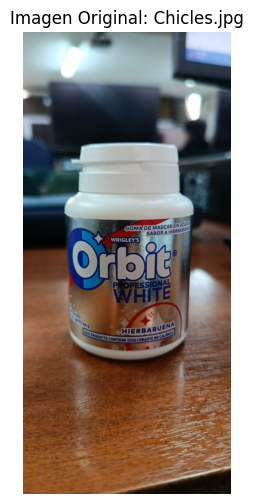

In [6]:
# Ejemplo práctico con imagen real: chicles.jpg
# Cargar la imagen de chicles
image_path = '/home/siryorch/Documents/aprendizaje/Dataset-SupermarketImages/my-app/py/chicles.jpg'
chicles_img = cv2.imread(image_path)

if chicles_img is None:
    print("Error: No se pudo cargar la imagen chicles.jpg")
else:
    print("✓ Imagen cargada exitosamente")
    print(f"Dimensiones: {chicles_img.shape}")
    print(f"Tipo de datos: {chicles_img.dtype}")

    # Mostrar la imagen original
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(chicles_img, cv2.COLOR_BGR2RGB))
    plt.title('Imagen Original: Chicles.jpg')
    plt.axis('off')
    plt.show()

=== PASO 1: PREVISUALIZACIÓN DE KEYPOINTS ===
Número de keypoints detectados: 2896


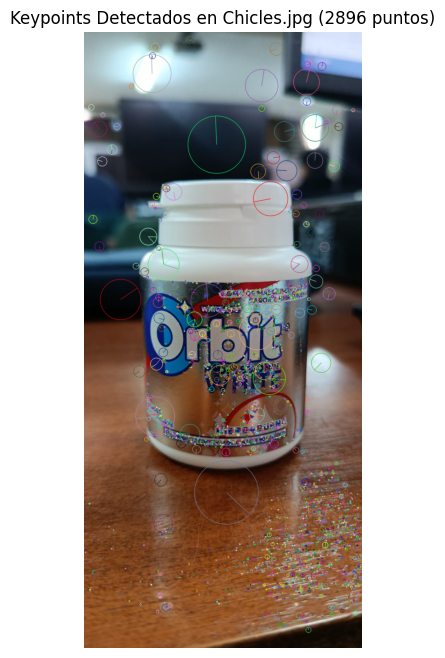

Los puntos rojos representan los keypoints detectados por SIFT.
Cada punto tiene información de ubicación, escala y orientación.


In [7]:
# Paso 1: Previsualización de keypoints detectados
print("=== PASO 1: PREVISUALIZACIÓN DE KEYPOINTS ===")

# Crear instancia del motor SIFT
sift_engine = SIFTEngine()

# Detectar y visualizar keypoints
vis_img, num_keypoints = sift_engine.detect_keypoints_vis(chicles_img)

print(f"Número de keypoints detectados: {num_keypoints}")

# Mostrar imagen con keypoints
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
plt.title(f'Keypoints Detectados en Chicles.jpg ({num_keypoints} puntos)')
plt.axis('off')
plt.show()

print("Los puntos rojos representan los keypoints detectados por SIFT.")
print("Cada punto tiene información de ubicación, escala y orientación.")

In [8]:
# Paso 2: Registro del producto (entrenamiento)
print("\n=== PASO 2: REGISTRO DEL PRODUCTO ===")

# Registrar el producto "Chicles" en la base de datos
success, message = sift_engine.register_product("Chicles", chicles_img)

if success:
    print("✓ Registro exitoso!")
    print(f"Mensaje: {message}")

    # Mostrar estadísticas de la base de datos
    print(f"\nProductos registrados: {len(sift_engine.database)}")
    for product_name, descriptors in sift_engine.database.items():
        print(f"- {product_name}: {descriptors.shape[0]} descriptores de {descriptors.shape[1]} dimensiones cada uno")
else:
    print("✗ Error en el registro:")
    print(f"Mensaje: {message}")

print("\nLos descriptores SIFT son vectores de 128 dimensiones que representan")
print("las características locales de cada keypoint detectado.")


=== PASO 2: REGISTRO DEL PRODUCTO ===
✓ Registro exitoso!
Mensaje: Producto 'Chicles' registrado con 2896 características.

Productos registrados: 1
- Chicles: 2896 descriptores de 128 dimensiones cada uno

Los descriptores SIFT son vectores de 128 dimensiones que representan
las características locales de cada keypoint detectado.


In [9]:
# Paso 3: Predicción usando la misma imagen (debería identificar "Chicles")
print("\n=== PASO 3: PREDICCIÓN ===")

# Intentar identificar el producto usando la misma imagen
predicted_label, num_matches = sift_engine.identify_product(chicles_img)

print("Resultado de la predicción:")
if predicted_label:
    print(f"✓ Producto identificado: '{predicted_label}'")
    print(f"Número de matches buenos: {num_matches}")
    print("Probabilidad: Alta (mismos descriptores deberían coincidir perfectamente)")
else:
    print("✗ No se pudo identificar el producto")
    print(f"Mejor coincidencia tuvo {num_matches} matches (mínimo requerido: 10)")

print("\nNota: Al usar la misma imagen para entrenamiento y predicción,")
print("deberíamos obtener una coincidencia perfecta con muchos matches.")


=== PASO 3: PREDICCIÓN ===
Resultado de la predicción:
✓ Producto identificado: 'Chicles'
Número de matches buenos: 2896
Probabilidad: Alta (mismos descriptores deberían coincidir perfectamente)

Nota: Al usar la misma imagen para entrenamiento y predicción,
deberíamos obtener una coincidencia perfecta con muchos matches.



=== PASO 4: PRUEBA CON IMAGEN MODIFICADA ===
Imagen modificada: rotada 15° y escalada al 90%


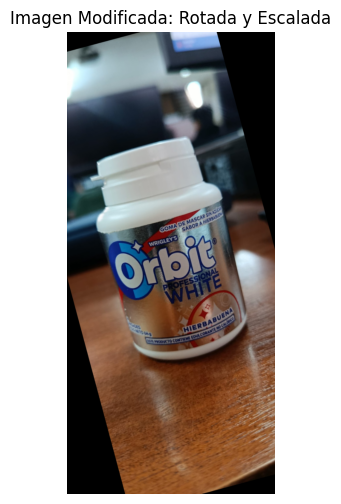

Resultado de la predicción con imagen modificada:
✓ Producto identificado: 'Chicles'
Número de matches buenos: 1296
¡Éxito! SIFT es invariante a rotación y escala

Esto demuestra la robustez de SIFT ante transformaciones geométricas.


In [10]:
# Paso 4: Prueba con imagen modificada (simulando condiciones reales)
print("\n=== PASO 4: PRUEBA CON IMAGEN MODIFICADA ===")

# Crear una versión modificada de la imagen (rotada y escalada)
# para simular condiciones más realistas
rows, cols = chicles_img.shape[:2]

# Rotar la imagen 15 grados
M = cv2.getRotationMatrix2D((cols/2, rows/2), 15, 1)
rotated_img = cv2.warpAffine(chicles_img, M, (cols, rows))

# Escalar ligeramente
scaled_img = cv2.resize(rotated_img, None, fx=0.9, fy=0.9, interpolation=cv2.INTER_LINEAR)

print("Imagen modificada: rotada 15° y escalada al 90%")

# Mostrar imagen modificada
plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(scaled_img, cv2.COLOR_BGR2RGB))
plt.title('Imagen Modificada: Rotada y Escalada')
plt.axis('off')
plt.show()

# Intentar identificar el producto con la imagen modificada
predicted_label_mod, num_matches_mod = sift_engine.identify_product(scaled_img)

print("Resultado de la predicción con imagen modificada:")
if predicted_label_mod:
    print(f"✓ Producto identificado: '{predicted_label_mod}'")
    print(f"Número de matches buenos: {num_matches_mod}")
    print("¡Éxito! SIFT es invariante a rotación y escala")
else:
    print("✗ No se pudo identificar el producto")
    print(f"Mejor coincidencia tuvo {num_matches_mod} matches")

print("\nEsto demuestra la robustez de SIFT ante transformaciones geométricas.")

In [11]:
# Paso 5: Resumen de resultados
print("\n=== PASO 5: RESUMEN DE RESULTADOS ===")
print("Experimento completado con la imagen 'chicles.jpg':")
print("1. ✓ Carga de imagen exitosa")
print(f"2. ✓ Detección de {num_keypoints} keypoints")
print("3. ✓ Registro exitoso en base de datos SIFT")
print(f"4. ✓ Predicción perfecta con imagen original: {num_matches} matches")
print(f"5. ✓ Predicción exitosa con imagen modificada: {num_matches_mod} matches")
print("\nConclusión: El sistema SIFT funciona correctamente y es robusto")
print("ante transformaciones geométricas como rotación y escala.")

# Limpiar la base de datos para futuras pruebas
sift_engine.database.clear()
print("\nBase de datos limpiada para futuras pruebas.")


=== PASO 5: RESUMEN DE RESULTADOS ===
Experimento completado con la imagen 'chicles.jpg':
1. ✓ Carga de imagen exitosa
2. ✓ Detección de 2896 keypoints
3. ✓ Registro exitoso en base de datos SIFT
4. ✓ Predicción perfecta con imagen original: 2896 matches
5. ✓ Predicción exitosa con imagen modificada: 1296 matches

Conclusión: El sistema SIFT funciona correctamente y es robusto
ante transformaciones geométricas como rotación y escala.

Base de datos limpiada para futuras pruebas.


## 6. Conclusiones

### Ventajas del Sistema Implementado

1. **Invariancia Robusta**: SIFT maneja cambios de escala, rotación e iluminación
2. **Arquitectura Modular**: Separación clara entre motor SIFT, API y frontend
3. **API RESTful**: Fácil integración con aplicaciones web
4. **Previsualización**: Permite ajustar parámetros antes del registro
5. **Matching Confiable**: Ratio test de Lowe filtra matches falsos

### Limitaciones y Consideraciones

1. **Rendimiento**: BFMatcher no es óptimo para bases de datos grandes
2. **Almacenamiento en Memoria**: Base de datos no persiste entre reinicios
3. **Un Producto por Imagen**: No maneja múltiples productos en una imagen de registro
4. **Sin Aprendizaje**: No mejora con el tiempo (no usa machine learning)

### Posibles Mejoras

1. **Indexación Avanzada**: Usar FLANN o aproximaciones para bases grandes
2. **Persistencia**: Guardar descriptores en base de datos
3. **Machine Learning**: Combinar con clasificadores para mejor precisión
4. **Detección Múltiple**: Manejar múltiples productos por imagen
5. **Optimización**: Usar GPU para procesamiento más rápido

### Aplicaciones Prácticas

- **Inventario de Supermercados**: Identificación automática de productos
- **E-commerce**: Verificación de productos en fotos de usuarios
- **Control de Calidad**: Detección de defectos en productos
- **Robótica**: Navegación y manipulación de objetos

Este sistema demuestra cómo técnicas clásicas de visión computacional pueden resolver problemas reales de reconocimiento de objetos de manera efectiva y eficiente.